In [1]:
! pip install datasets transformers[sentencepiece] lmppl

In [ ]:
pip install datasets

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
# model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

In [ ]:
# #ignore this block
# import lmppl

# scorer = lmppl.LM('gpt2')
# text = [
#     'sentiment classification: I dropped my laptop on my knee, and someone stole my coffee. I am happy.',
#     'sentiment classification: I dropped my laptop on my knee, and someone stole my coffee. I am sad.'
# ]
# ppl = scorer.get_perplexity(text)
# print(list(zip(text, ppl)))

# print(f"prediction: {text[ppl.index(min(ppl))]}")



In [2]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1", split='train', streaming=True)
# Take only the first 1 million rows
ds = dataset.take(1000000)
# Convert the streaming dataset to a list or a smaller dataset if needed
ds = list(ds)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# import lmppl

# # Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
# model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")



# import lmppl
# import pandas as pd

# def is_index_in_check_point(start_index, end_index, save_points):
#     for i in save_points:
#         if i >= start_index and i < end_index:
#             print(f'found the check point: {i}')
#             return True
#     return False

# def main(num, batch_size=16, start_index=350017):
#     ppl = []
#     save_points = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 800000, len(ds['train'])]
#     progress_marker = 10000

#     # Initialize scorer
#     scorer = lmppl.LM('gpt2')

#     # Adjust the number of batches to start from start_index
#     num_batches = ((num - start_index) + batch_size - 1) // batch_size

#     for batch_index in range(num_batches):

#         start_idx = start_index + batch_index * batch_size
#         end_idx = min(start_idx + batch_size , num)

#         batch_texts = [ds['train'][i]['text'] for i in range(start_idx, end_idx)]
#         batch_ppl = scorer.get_perplexity(batch_texts)

#         # Ensure batch_ppl is not stored as a list
#         if isinstance(batch_ppl, list):
#             ppl.extend(batch_ppl)
#         else:
#             ppl.append(batch_ppl)

#         if batch_index % (progress_marker // batch_size) == 0:
#             print(f'Current batch index is {batch_index} (text index: {start_idx}-{end_idx})')

#         # Save DataFrame at specified intervals
#         if is_index_in_check_point(start_idx, end_idx, save_points):
#             output = pd.DataFrame({'Id': range(start_index, start_index + len(ppl)), 'Perplexity': ppl})
#             output.to_csv(f'output_{end_idx}.csv', index=False)
#             print(f"Saved up to index {end_idx}.")

#     # Final save
#     output = pd.DataFrame({'Id': range(start_index, start_index + len(ppl)), 'Perplexity': ppl})
#     output.to_csv('output_final.csv', index=False)

#     return output




iteration 2

In [3]:
import lmppl
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM




# Load model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2").to(device)
# Use the existing `eos_token` as the `pad_token`
tokenizer.pad_token = tokenizer.eos_token
def is_index_in_check_point(start_index, end_index, save_points):
    for i in save_points:
        if i >= start_index and i < end_index:
            print(f'found the checkpoint: {i}')
            return True
    return False

def get_perplexity(batch_texts):
    inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        perplexity = torch.exp(loss)

    # Ensure perplexity is returned as a list
    if isinstance(perplexity, torch.Tensor) and perplexity.numel() == 1:
        return [perplexity.item()]

    return perplexity.cpu().numpy().tolist()


def main(num, batch_size=16, start_index=40):
    ppl = []
    save_points = set([50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 800000, len(ds)])
    progress_marker = 10000

    # Initialize scorer (using the GPU-accelerated function)
    num_batches = ((num - start_index) + batch_size - 1) // batch_size

    for batch_index in range(num_batches):
        start_idx = start_index + batch_index * batch_size
        end_idx = min(start_idx + batch_size, num)

        batch_texts = [ds[i]['text'] for i in range(start_idx, end_idx)]
        batch_ppl = get_perplexity(batch_texts)

        ppl.extend(batch_ppl)

        if batch_index % (progress_marker // batch_size) == 0:
            print(f'Current batch index is {batch_index} (text index: {start_idx}-{end_idx})')

        if is_index_in_check_point(start_idx, end_idx, save_points):
            output = pd.DataFrame({'Id': range(start_index, start_index + len(ppl)), 'Perplexity': ppl})
            output.to_csv(f'output_{end_idx}.csv', index=False)
            print(f"Saved up to index {end_idx}.")

    # Final save
    output = pd.DataFrame({'Id': range(start_index, start_index + len(ppl)), 'Perplexity': ppl})
    output.to_csv('output_final.csv', index=False)

    return output


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [4]:
# data_length = len(ds['train'])
ppl_list = main(100)


Current batch index is 0 (text index: 40-56)


In [ ]:
print(len(ds['train']))

1000000


In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import files


uploaded = files.upload()

Saving merged_file.csv to merged_file (2).csv


In [ ]:

from google.colab import files
files.download('merged_file.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv("merged_file.csv")

In [ ]:
df.describe()

,Id,Perplexity
count,650016.000000,6.500160e+05
mean,324994.423374,4.229003e+04
std,187640.423141,3.353897e+07
min,0.000000,1.069895e+00
25%,162487.750000,1.620595e+01
50%,324991.500000,2.347842e+01
75%,487496.250000,3.424957e+01
max,650000.000000,2.703992e+10


from matplotlib import pyplot as plt
_df_0['Id'].plot(kind='hist', bins=20, title='Id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Perplexity'].plot(kind='hist', bins=20, title='Perplexity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('index').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Id', y='Perplexity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Id'].plot(kind='line', figsize=(8, 4), title='Id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Perplexity'].plot(kind='line', figsize=(8, 4), title='Perplexity')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='Id', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['index'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='Perplexity', y='index', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

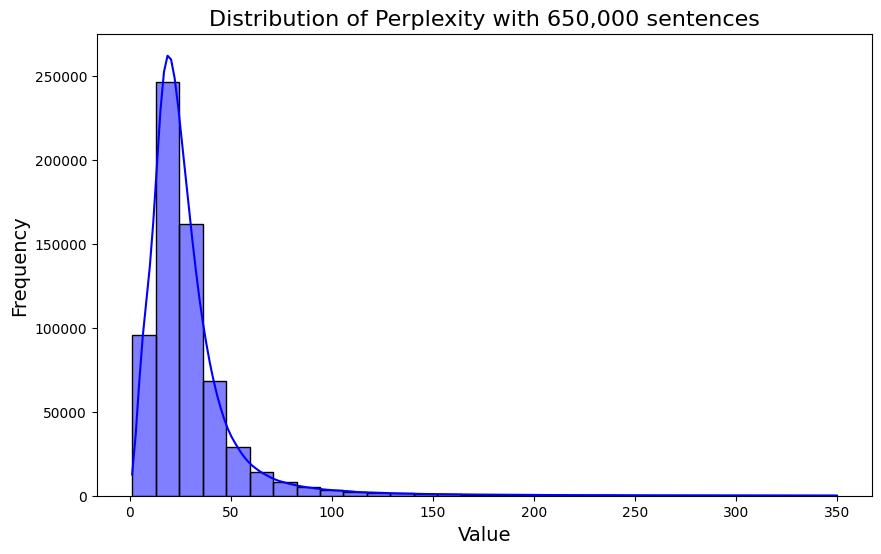

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


perplexity_values = df['Perplexity']
# Filter data to include only values less than or equal to the cutoff
cutoff = 350
filtered_data = perplexity_values[perplexity_values <= cutoff]

# Plot with the filtered data
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data, bins=30, color='blue', kde=True)

# Set titles and labels
plt.title('Distribution of Perplexity with 650,000 sentences', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()



In [ ]:
column_name = 'Perplexity'
quant = df[column_name].quantile(0.99)
print(quant)

344.0663279843978


In [ ]:
df_new = df[df[column_name] < quant]

In [ ]:
df_new.describe()

,Id,Perplexity
count,643515.000000,643515.000000
mean,324953.885642,29.242834
std,187629.293240,26.360315
min,0.000000,1.069895
25%,162458.500000,16.132402
50%,324955.000000,23.322495
75%,487411.500000,33.775134
max,650000.000000,344.014873


In [ ]:
q_high =  df_new[column_name].quantile(0.80)
q_low = df[column_name].quantile(0.33)
print(q_high)

37.27417842163127


In [ ]:
df_low = df[df[column_name] < q_low]
df_middle = df[(df[column_name] >= q_low) & (df[column_name] <= q_high)]
df_high = df[df[column_name] > q_high]

In [ ]:
df_low.describe()

,Id,Perplexity
count,214505.000000,214505.000000
mean,325106.635482,12.567415
std,187489.178178,4.214020
min,1.000000,1.069895
25%,162616.000000,9.454927
50%,325100.000000,13.397655
75%,487438.000000,16.132392
max,650000.000000,18.502115


In [ ]:
original_dat

In [ ]:

# Load the original dataset
original_df = original_dataset['train'].to_pandas()

# Load the split perplexity datasets
low_perplexity_df = df_low
medium_perplexity_df = df_middle
high_perplexity_df = df_high

# Merge with the original dataset to get the sentences
low_sentences_df = pd.merge(low_perplexity_df, original_df, left_on='id', right_on='num_rows')
medium_sentences_df = pd.merge(medium_perplexity_df, original_df, left_on='id', right_on='num_rows')
high_sentences_df = pd.merge(high_perplexity_df, original_df, left_on='id', right_on='num_rows')

# Save the merged dataframes to new CSV files
low_sentences_df.to_csv('low_perplexity_sentences.csv', index=False)
medium_sentences_df.to_csv('medium_perplexity_sentences.csv', index=False)
high_sentences_df.to_csv('high_perplexity_sentences.csv', index=False)

KeyError: 'num_rows'

In [ ]:
df_low.to_csv('low_values.csv', index=False)
df_middle.to_csv('middle_values.csv', index=False)
df_high.to_csv('high_values.csv', index=False)